<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Init-data" data-toc-modified-id="Init-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Init data</a></span><ul class="toc-item"><li><span><a href="#Estaciones" data-toc-modified-id="Estaciones-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Estaciones</a></span></li><li><span><a href="#Data-Mediciones" data-toc-modified-id="Data-Mediciones-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Data Mediciones</a></span></li></ul></li><li><span><a href="#EDA-2" data-toc-modified-id="EDA-2-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>EDA 2</a></span><ul class="toc-item"><li><span><a href="#Identificar-días-interesantes" data-toc-modified-id="Identificar-días-interesantes-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Identificar días interesantes</a></span></li></ul></li></ul></div>

In [1]:
import pandas as pd
from joblib import Parallel, delayed
import numpy as np
import json
from pathlib import Path
import altair as alt
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt
import matplotlib as mpl
import plotly.plotly as py
import plotly.graph_objs as go
import mplleaflet

pd.options.mode.chained_assignment = None
pd.set_option('max_columns', 100)

%matplotlib inline

# Init data

## Estaciones

In [2]:
estaciones = pd.read_csv('/data/calidad_aire_presidencia/data_estaciones_sinaica.csv')
mask = (estaciones.lat.between(14, 34.5)) & (estaciones.long.between(-120, -70))
estaciones = estaciones[mask].rename(columns={'id':'estacionesid'})

print(estaciones.shape)
estaciones.head()

(180, 8)


,_id,lat,long,estacionesid,nombre,codigo,redesid,date-insert
0,5b8850e3e2705c1932e82ff8,21.873311,-102.320803,31,CBTIS,CBT,30,2018-08-30 20:17:39.218
1,5b8850e3e2705c1932e82ff9,21.846392,-102.288431,32,Secretaría de Medio Ambiente,SMA,30,2018-08-30 20:17:39.218
2,5b8850e3e2705c1932e82ffa,21.883781,-102.295825,33,Centro,CEN,30,2018-08-30 20:17:39.218
3,5b8850e3e2705c1932e82ffb,31.859917,-116.593722,36,Secundaria,SPABC20,31,2018-08-30 20:17:39.218
4,5b8850e3e2705c1932e82ffc,32.631317,-115.444631,38,UABC,SPABC12,32,2018-08-30 20:17:39.218


## Data Mediciones

In [3]:
mediciones = pd.read_csv('/data/calidad_aire_presidencia/data_mediciones_todas_estaciones_2.csv')
print(mediciones.shape)
mediciones.head()

(3240000, 8)


,city,estacionesid,fecha,hora,parametro,state,validoorig,valororig
0,Durango,58,2018-08-01,13,PM10,Durango,1,988.61
1,Durango,58,2018-08-01,14,PM10,Durango,1,988.61
2,Durango,58,2018-08-01,15,PM10,Durango,1,988.60
3,Durango,58,2018-08-01,16,PM10,Durango,1,988.63
4,Durango,58,2018-08-01,17,PM10,Durango,1,988.63


In [4]:
estaciones_ciudad = mediciones[['city', 'state', 'estacionesid']].drop_duplicates()
print(estaciones_ciudad.shape)
estaciones_ciudad.head()

(123, 3)


,city,state,estacionesid
0,Durango,Durango,58
6543,Durango,Durango,59
33554,Durango,Durango,60
65683,Gómez Palacio,Durango,65
80484,Celaya,Guanajuato,68


In [5]:
estaciones_ciudad.groupby('city').estacionesid.nunique().sort_values(ascending=False).head()

city
Valle de México    32
Monterrey          11
Guadalajara        10
Toluca              6
León                3
Name: estacionesid, dtype: int64

# EDA 2

In [9]:
mediciones.groupby('parametro').valororig.describe(percentiles=[0.25, 0.9, 0.98, 0.99])

,count,mean,std,min,25%,50%,90%,98%,99%,max
parametro,,,,,,,,,,
CO,469040.0,131.256801,52200.737311,-630.230,0.400000,0.629000,2.000,5.713844,7.837122,3.572734e+07
NO2,468017.0,0.186630,1.778766,-6.693,0.007113,0.013800,0.036,0.066000,7.633736,5.062300e+01
O3,535060.0,0.002173,6.968772,-809.170,0.011910,0.025058,0.061,0.089000,0.106000,2.579400e+02
PM10,450187.0,71.679258,153.992616,-278.320,26.000000,42.000000,101.000,970.000000,973.090000,2.033300e+04
PM2.5,345758.0,50.087718,168.708588,-9999.000,11.575324,19.127033,46.000,906.520019,970.880000,1.741900e+03
SO2,467808.0,0.052523,0.828627,-10.918,0.001200,0.003000,0.013,0.241387,1.943223,3.072526e+02
TMP,504130.0,29.230095,87.786693,-99.000,14.330000,18.900000,28.500,588.004200,604.660000,3.564400e+03


In [7]:
# Sacado de acá (no son los datos más actualizados, se usan como referencia)
# http://dgeiawf.semarnat.gob.mx:8080/ibi_apps/WFServlet?IBIF_ex=D3_R_AIRE01_04&IBIC_user=dgeia_mce&IBIC_pass=dgeia_mce
# limites_nom = {'CO':50, 'NO2':2, 'O3':0.6, 'SO2':1, 'PM10':600, 'PM2.5':600}

# Estos límites son usando el percentil ~98%
limites_98 = {'CO':10, 'NO2':1, 'O3':0.2, 'SO2':0.3, 'PM10':600, 'PM2.5':600}

def filtra_mediciones(df_mediciones, parametro):
    # Las mediciones no pueden ser negativas, también vamos a ignorar ceros, menos en temperatura
    if parametro!='TMP':
        filtered_data = df_mediciones[(df_mediciones.valororig>0) &
                                      (df_mediciones.valororig<limites_98[parametro])]
    else:
        filtered_data = df_mediciones[df_mediciones.valororig.between(-20, 50)]
        
    return filtered_data

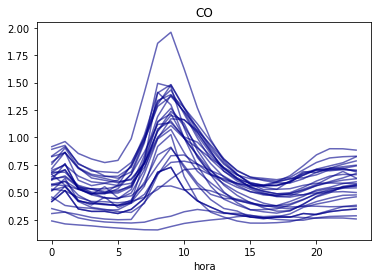

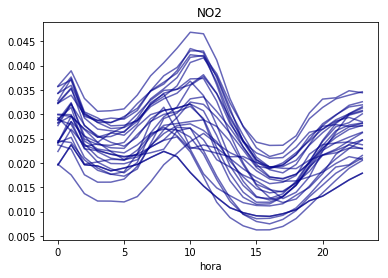

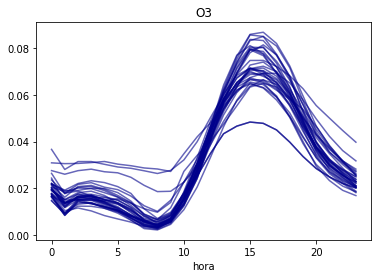

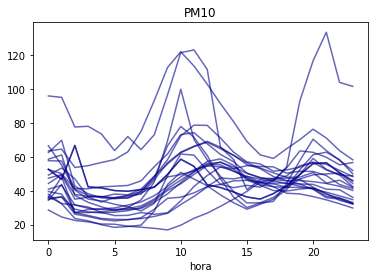

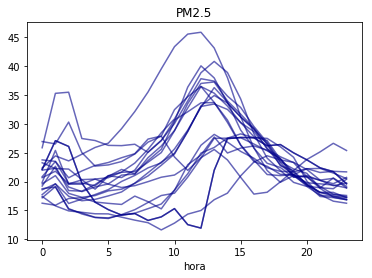

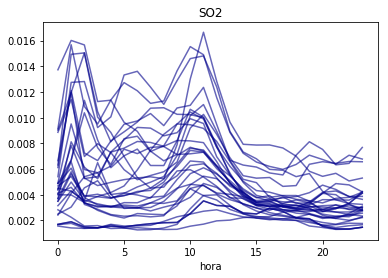

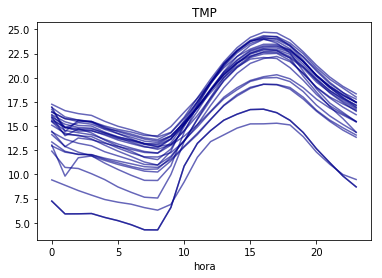

In [8]:
# Gráficas de promedio por hora del día por parámetro para cada estación de una ciudad
for parametro, df_mediciones in mediciones[mediciones.city=='Valle de México'].groupby('parametro'):
    aux = filtra_mediciones(df_mediciones, parametro)
    fig = aux.groupby('estacionesid').apply(
        lambda x: x.groupby('hora').valororig.mean().sort_index().plot(alpha=0.6, color='darkblue',
                                                                       title=parametro)
    )
    plt.show()

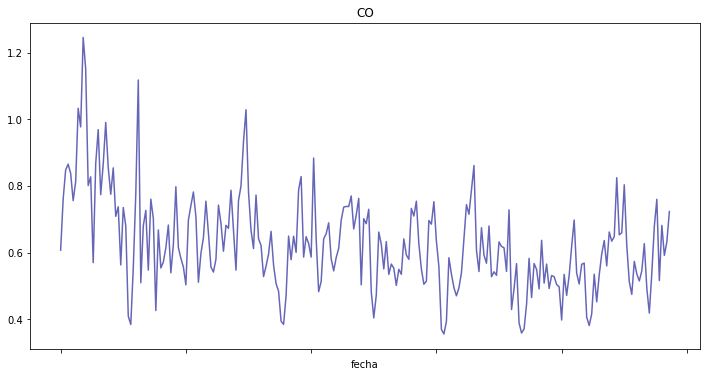

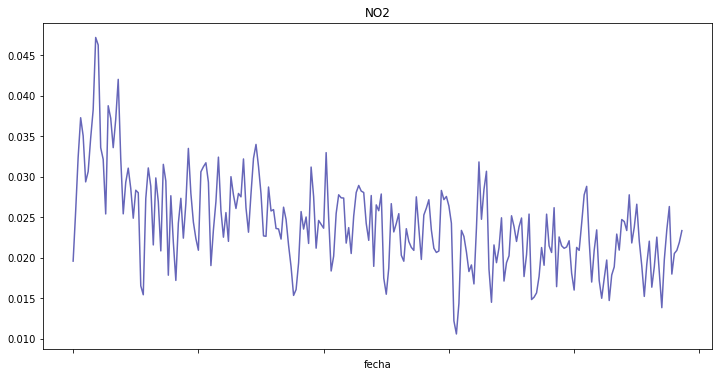

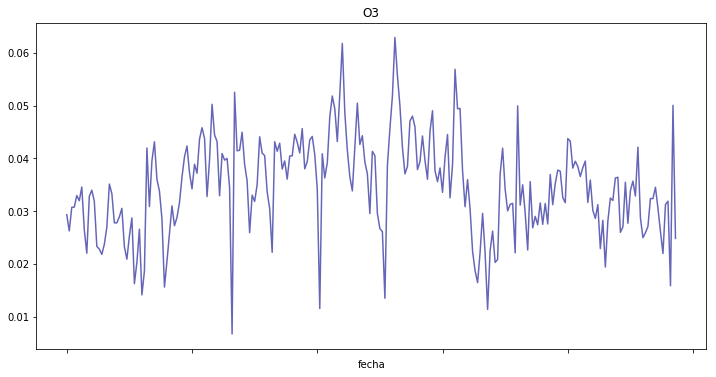

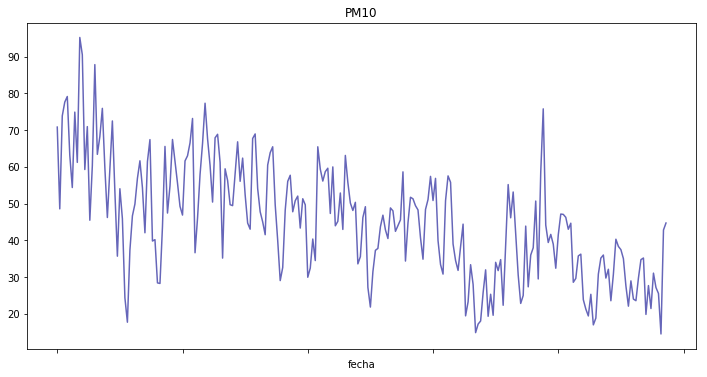

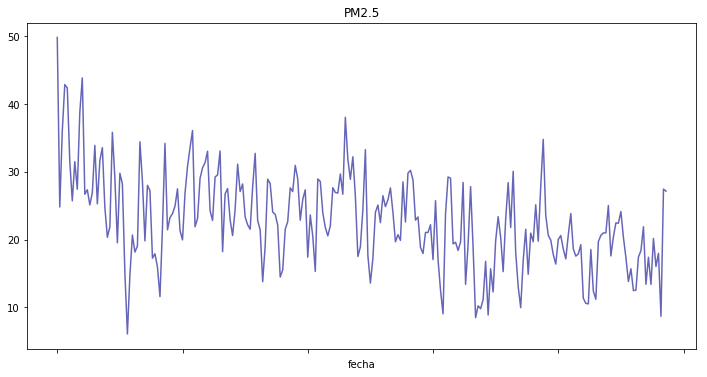

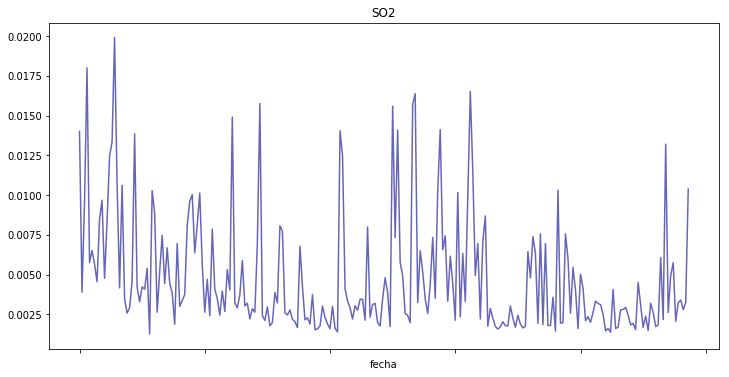

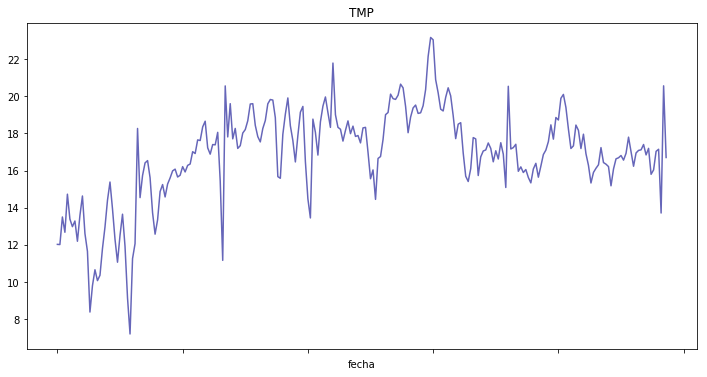

In [46]:
# Gráficas por día, promediando todas las estaciones de una ciudad por parámetro
for parametro, df_mediciones in mediciones[mediciones.city=='Valle de México'].groupby('parametro'):
    aux = filtra_mediciones(df_mediciones, parametro)
    aux.sort_values('fecha', inplace=True)
    fig = aux.groupby('fecha').valororig.mean().plot(alpha=0.6, color='darkblue',
                                                                  title=parametro, figsize=(12, 6))
    plt.show()

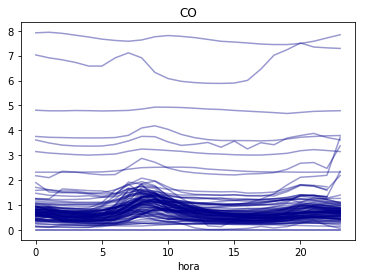

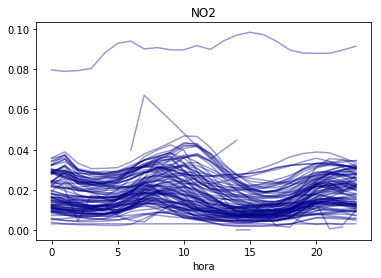

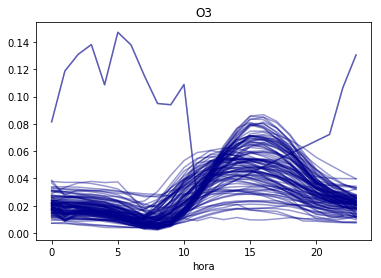

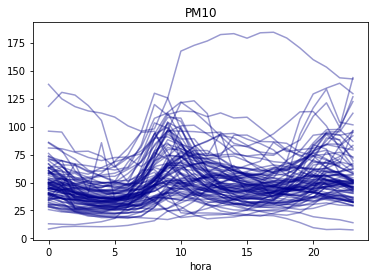

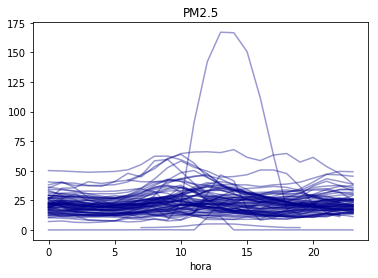

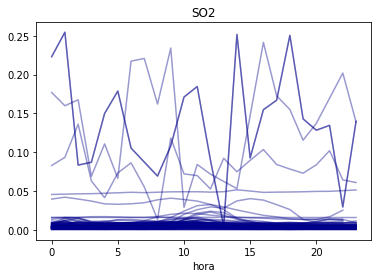

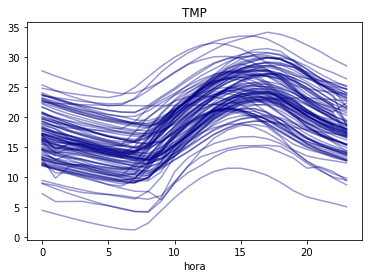

In [47]:
# Gráficas de promedio por hora del día por parámetro para cada estación
for parametro, df_mediciones in mediciones.groupby('parametro'):
    aux = filtra_mediciones(df_mediciones, parametro)
    fig = aux.groupby('estacionesid').apply(
        lambda x: x.groupby('hora').valororig.mean().sort_index().plot(alpha=0.4, color='darkblue',
                                                                       title=parametro)
    )
    plt.show()

Hipótesis: El volumen de NO2 ~4 horas antes es buen predictor de la cantidad de O3.

R: Parece que no.

In [48]:
mediciones_estacion = mediciones[mediciones.estacionesid==259]
mediciones_estacion = [filtra_mediciones(df, i) for i, df in mediciones_estacion.groupby('parametro')]
mediciones_estacion = pd.concat(mediciones_estacion)

mediciones_estacion['fecha_hora']  = pd.to_datetime(mediciones_estacion.fecha + ' ' +
                                            mediciones_estacion.hora.astype(str) +':00:00')
mediciones_estacion.sort_values('fecha_hora', inplace=True)
print(mediciones_estacion.shape)
mediciones_estacion.head()

(28924, 9)


,city,estacionesid,fecha,hora,parametro,state,validoorig,valororig,fecha_hora
2271584,Valle de México,259,2018-01-01,0,O3,Ciudad de México,1,0.017,2018-01-01
1502446,Valle de México,259,2018-01-01,0,NO2,Ciudad de México,1,0.040,2018-01-01
2276384,Valle de México,259,2018-01-01,0,SO2,Ciudad de México,1,0.009,2018-01-01
2262392,Valle de México,259,2018-01-01,0,CO,Ciudad de México,1,1.100,2018-01-01
2267246,Valle de México,259,2018-01-01,0,NO2,Ciudad de México,1,0.040,2018-01-01


In [50]:
pivot_mediciones = mediciones_estacion[mediciones_estacion.parametro.isin(['NO2', 'O3', 'TMP'])]

pivot_mediciones = pivot_mediciones.pivot_table('valororig', 'fecha_hora', 'parametro')

pivot_mediciones['shift_NO2'] = pivot_mediciones.NO2.shift(5)

pivot_mediciones = pivot_mediciones.apply(lambda x: (x-x.mean())/x.std())
# pivot_mediciones = pivot_mediciones.apply(lambda x: (x-x.min())/(x.max()-x.min()))
pivot_mediciones.head(10)

parametro,NO2,O3,TMP,shift_NO2
fecha_hora,,,,
2018-01-01 00:00:00,1.432791,-0.748013,NaN,NaN
2018-01-01 01:00:00,0.738211,-0.682308,-0.998593,NaN
2018-01-01 02:00:00,0.130454,-0.550898,-1.020841,NaN
2018-01-01 03:00:00,-0.390481,-0.419489,-1.043088,NaN
2018-01-01 04:00:00,-0.737771,-0.320931,-1.154328,NaN
2018-01-01 05:00:00,-0.390481,-0.583751,-1.399056,1.432985
2018-01-01 06:00:00,-0.390481,-0.715161,-1.688279,0.738646
2018-01-01 07:00:00,-0.043191,-0.879423,-1.821767,0.131100
2018-01-01 08:00:00,0.390921,-1.109390,-1.866263,-0.389654


In [51]:
pivot_mediciones.corr()

parametro,NO2,O3,TMP,shift_NO2
parametro,,,,
NO2,1.000000,-0.278353,-0.283677,0.092421
O3,-0.278353,1.000000,0.794505,0.260503
TMP,-0.283677,0.794505,1.000000,0.043269
shift_NO2,0.092421,0.260503,0.043269,1.000000


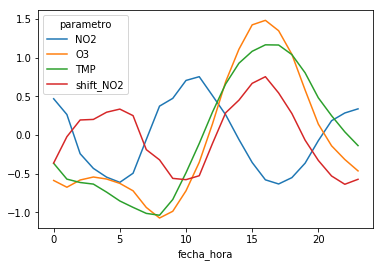

In [52]:
pivot_mediciones.groupby(pivot_mediciones.index.hour).mean().plot()

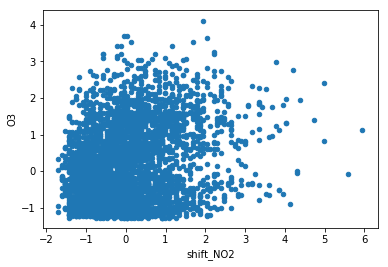

In [54]:
pivot_mediciones.plot.scatter(x='shift_NO2', y='O3')

In [58]:
aux = pivot_mediciones[pivot_mediciones.index.month.isin([5, 6])]

data = [go.Scatter(x=aux.index,
                   y=aux.O3, name='O3'),
        go.Scatter(x=aux.index, 
                   y=aux.TMP, name='TMP'),
        go.Scatter(x=aux.index, 
                   y=aux.NO2, name='NO2')]

py.iplot(data, filename='pandas-time-series')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~fickincool/0 or inside your plot.ly account where it is named 'pandas-time-series'


## Identificar días interesantes

In [79]:
# Gráficas por día, promediando todas las estaciones de una ciudad por parámetro
for parametro, df_mediciones in mediciones[mediciones.city=='Valle de México'].groupby('parametro'):
    aux = filtra_mediciones(df_mediciones, parametro)
    aux['fecha'] = pd.to_datetime(aux.fecha)
    aux['dia_semana'] = aux.fecha.dt.weekday_name
    aux.sort_values('fecha', inplace=True)
    # aux = aux.groupby('fecha').valororig.mean()
    if parametro == 'O3':
        break

In [80]:
menos_ = aux.groupby('fecha').valororig.mean().sort_values().head(10).index
aux[aux.fecha.isin(menos_)][['fecha', 'dia_semana']].drop_duplicates()

,fecha,dia_semana
2514648,2018-01-28,Sunday
1953894,2018-01-31,Wednesday
1996032,2018-02-01,Thursday
2719196,2018-02-09,Friday
2389040,2018-03-08,Thursday
2247121,2018-04-12,Thursday
2171617,2018-05-08,Tuesday
1489950,2018-06-14,Thursday
1956776,2018-06-18,Monday
1894707,2018-09-01,Saturday


In [86]:
url_la_jornada = 'https://www.jornada.com.mx/%i/%02i/%02i/'

In [87]:
mas_ = aux.groupby('fecha').valororig.mean().sort_values(ascending=False).head(10).index
for i in mas_:
    print(url_la_jornada %(i.year, i.month, i.day))

https://www.jornada.com.mx/2018/05/12/
https://www.jornada.com.mx/2018/04/21/
https://www.jornada.com.mx/2018/06/05/
https://www.jornada.com.mx/2018/05/13/
https://www.jornada.com.mx/2018/03/09/
https://www.jornada.com.mx/2018/04/20/
https://www.jornada.com.mx/2018/04/17/
https://www.jornada.com.mx/2018/05/11/
https://www.jornada.com.mx/2018/04/27/
https://www.jornada.com.mx/2018/02/28/


In [71]:
menos_

DatetimeIndex(['2018-06-03', '2018-07-06', '2018-06-02', '2018-07-07',
               '2018-08-02', '2018-01-29', '2018-03-31', '2018-07-05',
               '2018-06-04', '2018-03-30'],
              dtype='datetime64[ns]', name='fecha', freq=None)